In [45]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 各パス指定

In [46]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

# 分類数設定

In [47]:
NUM_CLASSES = 6

# 学習データ読み込み

In [48]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [49]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [51]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [52]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_4 (Dropout)         (None, 42)                0         
                                                                 
 dense_6 (Dense)             (None, 20)                860       
                                                                 
 dropout_5 (Dropout)         (None, 20)                0         
                                                                 
 dense_7 (Dense)             (None, 10)                210       
                                                                 
 dense_8 (Dense)             (None, 6)                 66        
                                                                 
Total params: 1136 (4.44 KB)
Trainable params: 1136 (4.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [53]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [54]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [55]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000


34/59 [================>.............] - ETA: 0s - loss: 1.8054 - accuracy: 0.2036 
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
59/59 [==============================] - 1s 5ms/step - loss: 1.7808 - accuracy: 0.2188 - val_loss: 1.7040 - val_accuracy: 0.3235
Epoch 2/1000
34/59 [================>.............] - ETA: 0s - loss: 1.7147 - accuracy: 0.2709
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
59/59 [==============================] - 0s 3ms/step - loss: 1.6986 - accuracy: 0.2832 - val_loss: 1.5766 - val_accuracy: 0.4229
Epoch 3/1000
 1/59 [..............................] - ETA: 0s - loss: 1.6704 - accuracy: 0.2891

/tmp/myenv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


32/59 [===============>..............] - ETA: 0s - loss: 1.6478 - accuracy: 0.3169
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
59/59 [==============================] - 0s 3ms/step - loss: 1.6301 - accuracy: 0.3262 - val_loss: 1.4728 - val_accuracy: 0.4891
Epoch 4/1000
49/59 [=======================>......] - ETA: 0s - loss: 1.5680 - accuracy: 0.3672
Epoch 4: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
59/59 [==============================] - 0s 4ms/step - loss: 1.5620 - accuracy: 0.3709 - val_loss: 1.3580 - val_accuracy: 0.5561
Epoch 5/1000
32/59 [===============>..............] - ETA: 0s - loss: 1.5102 - accuracy: 0.3870
Epoch 5: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
59/59 [==============================] - 0s 3ms/step - loss: 1.4886 - accuracy: 0.4020 - val_loss: 1.2431 - val_accuracy: 0.6446
Epoch 6/1000
53/59 [=========================>....] - ETA: 0s - loss: 1.4224 - accuracy: 0.4444
Epoch 6: savin

In [56]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

 1/20 [>.............................] - ETA: 0s - loss: 0.4246 - accuracy: 0.9453

20/20 [==============================] - 0s 4ms/step - loss: 0.4185 - accuracy: 0.9374


In [57]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [58]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 62ms/step
[3.2905243e-02 2.3387214e-03 1.7475383e-03 6.8908185e-01 3.6236280e-04
 2.7356434e-01]
3


# 混同行列

78/78 [==============================] - 0s 1ms/step


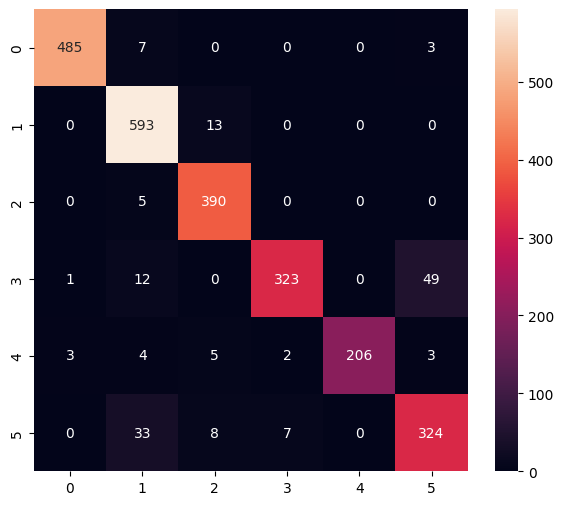

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       495
           1       0.91      0.98      0.94       606
           2       0.94      0.99      0.96       395
           3       0.97      0.84      0.90       385
           4       1.00      0.92      0.96       223
           5       0.85      0.87      0.86       372

    accuracy                           0.94      2476
   macro avg       0.94      0.93      0.94      2476
weighted avg       0.94      0.94      0.94      2476



In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [60]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)

/tmp/myenv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [61]:
# モデルを変換(量子化)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier_3.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmpn51zgumj/assets


INFO:tensorflow:Assets written to: /tmp/tmpn51zgumj/assets
2024-01-12 09:54:56.673553: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-01-12 09:54:56.673587: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-01-12 09:54:56.673790: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpn51zgumj
2024-01-12 09:54:56.674826: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-01-12 09:54:56.674840: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpn51zgumj
2024-01-12 09:54:56.677601: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-01-12 09:54:56.724395: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpn51zgumj
2024-01-12 09:54:56.739362: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

6660

# 推論テスト

In [62]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [63]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [64]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [65]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 282 µs, sys: 20 µs, total: 302 µs
Wall time: 223 µs


In [66]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[3.2905266e-02 2.3387247e-03 1.7475429e-03 6.8908161e-01 3.6236388e-04
 2.7356446e-01]
3
